In [1]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np

%tensorflow_version 1.15
import tensorflow as tf
tf.enable_eager_execution()

!pip install git+https://github.com/jnunez10010/data-driven-advection.git
from datadrivenpdes.core import equations
from datadrivenpdes.core import grids
import datadrivenpdes as pde
from datadrivenpdes.core import polynomials
from datadrivenpdes.core import states
import scipy as sp


import xarray as xr

!pip install animatplot
import animatplot as amp

from matplotlib.animation import FuncAnimation, PillowWriter

from IPython.display import Image
from IPython.display import HTML

import matplotlib.animation as animation


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Cloning https://github.com/jnunez10010/data-driven-advection.git to /tmp/pip-req-build-nkx20r9g
  Running command git clone -q https://github.com/jnunez10010/data-driven-advection.git /tmp/pip-req-build-nkx20r9g
     |████████████████████████████████| 9.6MB 5.3MB/s 
     |████████████████████████████████| 2.3MB 36.5MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 153kB 55.8MB/s 
     |████████████████████████████████| 829kB 36.3MB/s 
  Created wheel for pde-superresolution-2d: filename=pde_superresolution_2d-0.0.0-cp37-none-any.whl size=78469 sha256=b5bbae97f274a3ff1d9de6580799eb2621bc16671c73477483a986a1fa4eb2b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxrn8_1v/wheels/ad/a4/a2/2ef47212bbe2a19c7a7a96c936001d7feeb8b3359f7395e372
  Created wheel for dill: filename=dill-0.3.1.1-cp37-

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

  Created wheel for animatplot: filename=animatplot-0.4.2-cp37-none-any.whl size=16509 sha256=8501ab37e7957c08bd3c485912687486e53820c7f8b724c689acaaec7b22a0e8
  Stored in directory: /root/.cache/pip/wheels/0f/ff/d5/82795202b7bf774ae60cbef1b7905c1d46dbc0ec2ec2a67719
Successfully built animatplot


# Defining a new equation

In this section we learn how to define a new equation. We will look at coupled reaction diffusion equations, aka the **Turing Equation**. They decscribe the evolution of two fields, $A$ and $B$, according to:
$$\begin{align}
\frac{\partial A}{\partial t} &= D_A\nabla^2 A + R_A(A,B)+S\\
\frac{\partial B}{\partial t} &= D_B\nabla^2 B + R_B(A,B)
\end{align}$$
$D_{A,B}$ are the diffusion constants of $A$ and $B$, $R_{A,B}$ are nonlinear reaction terms and $S$ is some constant source term. For example, we'll take
$$\begin{align}
R_A&=A(1-A^2)-\alpha B & 
R_B&=\beta(A-B)
\end{align}$$
where $\alpha$ and $\beta$ are model parameters. For simplicity, we'll implelment the equation in one spatial dimension. 

## Equation Keys
Because the computational framework is [fully differentiable](https://en.wikipedia.org/wiki/Differentiable_programming), defining an equation requires specifiying in advance what are the quantities that are used in calcualting time derivatives. These are called **keys** and are stored in the `equation` attribute `key_definitions`. In our case, to calculate the time evolution we need $A, B, \partial_{xx}A, \partial_{xx}B $ and $S$.

The auxilliary function `states.StateDefinition` defines these keys. Its input arguments are:
* `name` - The base name of the field. For example, the field $\partial_{xx} A$ is derived from the base field `A`.
* `tensor_indices` - In 2D and above, specify whether a field is a component of a tensor (like $v_x$ and $v_y$ in the advection example).
* `derivative_orders` - Specifies whether a key is a spatial derivative of a different key.
* `offset` - Specifies whether a field is evaluated off the center point of a grid (useful for staggered grids, e.g. finite volume schemes)

For example, in our case the `key_definitions` for $A$ and $\partial_{xx}A$ are

```python
key_definitions = {
    'A': states.StateDefinition(name='A',     
                  tensor_indices=(),          # Not used in one dimenional equations
                  derivative_orders=(0,0,0),  # A is not a derivative of anything else
                  offset=(0,0)),              # A is evaluated on the centerpoints of the grid
    
    'A_xx': states.StateDefinition(name='A',       # A_xx is is derived from A
                     tensor_indices=(),
                     derivative_orders=(2, 0, 0),  # Two derivatives on the x axis
                     offset=(0, 0)),               
  }
```
There are two types of keys: those that evolve in time, in our case $A$ and $B$, and constant ones, in our case $S$ (and in the Advection Diffusion example - the velocity field $v$). When defining the equation we need to set the attributes `evolving_keys` and `constant_keys`, which are both python `set`s. 

The different keys of an `Equation` instance can be inspected with
```python
equation.all_keys        # in our case: {'A', 'A_xx', 'B', 'B_xx', 'Source'}
equation.base_keys       # in our case: {'A', 'B', 'Source'}
equation.evolving_keys   # in our case: {'A', 'B'}
equation.constant_keys   # in our case: {'Source'}
```


## Defining the equation

Here is a full definition of the equation:

In [ ]:
def smooth_random_field(N, amp=0.1, np_random_state=None):
    """
    generates a random field of shape (N,1) and smoothes it a bit
    """
    if np_random_state is None:
      np_random_state = np.random.RandomState()
    noise=np_random_state.randn(N)  
    kernel=np.exp(-np.linspace(-6,6,N)**2)  
    return amp*sp.ndimage.convolve(noise, kernel, mode='wrap')[:,np.newaxis]

def make_multi_rf(N, np_random_state=[], width_list=[]):
  c_list = []
  amp_list = np.arange(0.1,1.0,0.1)
  for amp in amp_list:
    c_temp = smooth_random_field(N, amp)
    c_list.append(c_temp)

  return np.array(c_list)

class TuringEquation(equations.Equation):

    DISCRETIZATION_NAME = 'finite_difference'
    METHOD = polynomials.Method.FINITE_DIFFERENCE
    MONOTONIC = False
    CONTINUOUS_EQUATION_NAME = 'Turing'

    key_definitions = {
        'A': states.StateDefinition(name='A',
                      tensor_indices=(),
                      derivative_orders=(0,0,0),
                      offset=(0,0)),
        'A_xx': states.StateDefinition(name='A',
                         tensor_indices=(),
                         derivative_orders=(2, 0, 0),
                         offset=(0, 0)),
        'B': states.StateDefinition(name='B',
                      tensor_indices=(),
                      derivative_orders=(0, 0, 0),
                      offset=(0, 0)),
        'B_xx': states.StateDefinition(name='B',
                         tensor_indices=(),
                         derivative_orders=(2, 0, 0),
                         offset=(0, 0)),
        'Source' : states.StateDefinition(name='Source',
                         tensor_indices=(),
                         derivative_orders=(0, 0, 0),
                         offset=(0, 0)),
    }
    evolving_keys = {'A', 'B'}
    constant_keys = {'Source'}

    def __init__(self, alpha, beta, D_A, D_B, timestep=1e-4):
        self.alpha = alpha
        self.beta = beta
        self.D_A = D_A
        self.D_B = D_B
        self._timestep = timestep
        super().__init__()
    
    def time_derivative(
          self, grid, A, A_xx, B, B_xx, Source):
        """See base class."""
        rA = self.reaction_A(A, B)
        rB = self.reaction_B(A, B)
        diff_A = self.D_A * A_xx
        diff_B = self.D_B * B_xx
        return {'A': rA + diff_A + Source,
                'B': rB + diff_B,}

    def reaction_A(self, A, B):
        return A - (A ** 3) - B + self.alpha

    def reaction_B(self, A, B):
        return (A - B) * self.beta

    def get_time_step(self, grid):
        return self._timestep

    def random_state(self, grid, seed=None, dtype=tf.float32):
        if seed is None:
            #R = np.random.RandomState()
            R = [np.random.RandomState(), np.random.RandomState()]
        else:
            #R = np.random.RandomState(seed=seed)
            R = [np.random.RandomState(seed=seed), np.random.RandomState(seed=seed)]

        state = {
          'A': make_multi_rf(N=grid.size_x, np_random_state=R).astype(np.float32),
          'B': make_multi_rf(N=grid.size_x, np_random_state=R).astype(np.float32),
          'Source': make_multi_rf(N=grid.size_x, np_random_state=R).astype(np.float32),
        }

        state = {k: tf.cast(v, dtype) for k, v in state.items()}
        return state

In [ ]:
eq = TuringEquation(alpha=-0.0001, beta=10, D_A=1, D_B=30)
NX=200*4
NY=1 # 1D can be obtained by haveing a y dimension of size 1
LX=200
grid_fine = grids.Grid(NX, NY, step=LX/NX)
grid_coarse = grids.Grid(NX//4, NY, step=LX/NX)
x, y=grid_fine.get_mesh()
x_coarse, y_coarse=grid_coarse.get_mesh()

initial_state = eq.random_state(grid=grid_fine, seed=12345)
initial_state_coarse = eq.random_state(grid=grid_coarse, seed=12345)
times = eq._timestep*np.arange(0, 1000, 20)
time_steps = np.arange(0, 256*4+1)
steps = np.arange(0, 256*4+1)
model = pde.core.models.FiniteDifferenceModel(eq,grid_fine)
#res = pde.core.integrate.integrate_times(model=model, state=initial_state, times=times, axis=0)
res = pde.core.integrate.integrate_steps(model, initial_state, time_steps)
print(res['A'].numpy().shape)
print(initial_state['A'].numpy().shape)

(1025, 9, 800, 1)
(9, 800, 1)


(1025, 9, 800, 1)

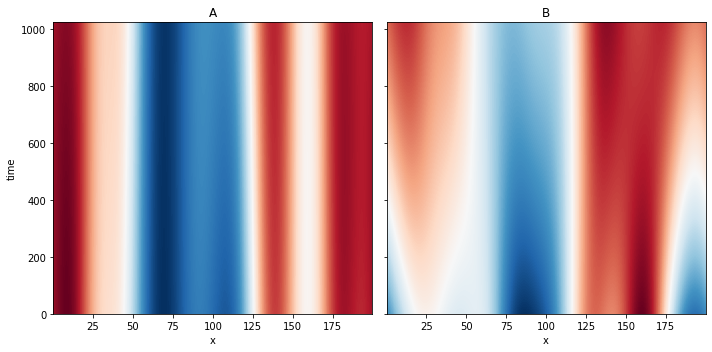

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x.flat, time_steps, res[k].numpy()[:,0,:,0].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
res['B'].numpy().shape

line


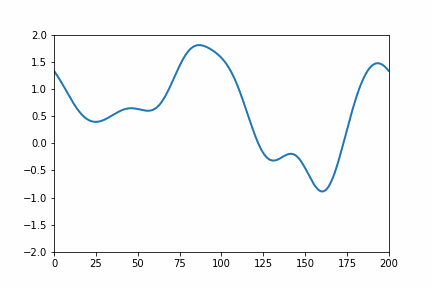

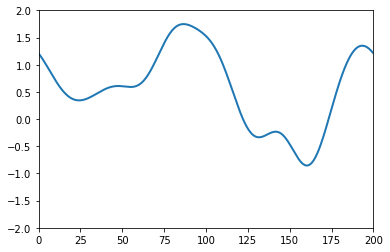

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(( 0, 200))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

print('line')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate_fine(i):
    y = res['B'].numpy()[i,0,...].squeeze()
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate_fine, init_func=init,
                               frames=50, interval=5, blit=True)

writer = PillowWriter(fps=5)  
anim.save("demo.gif", writer=writer) 


Image(open('demo.gif','rb').read())

In [ ]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):

  # use high-order traditional scheme as reference model
  eq = TuringEquation(alpha=-0.0001, beta=10, D_A=1, D_B=30)
  key_defs = eq.key_definitions

  # reference model runs at high resolution
  model = pde.core.models.FiniteDifferenceModel(eq,fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  print('coarse ratio : ', coarse_ratio)
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)
  print('steps : ', steps)

  # solve advection at high resolution
  integrated_fine = pde.core.integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = pde.core.tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return steps, integrated_fine, integrated_coarse


def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4, evolving_keys={}):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  sample_key = list(train_input.keys())[0]
  print('sample key :', sample_key)
  n_time, n_sample, n_x, n_y = train_input[sample_key].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  train_output={}
  for ii in ['A','B']:
    output_list = []
    for shift in range(1, example_time_steps+1):
      # output time series, starting from each single time step
      output_slice = integrated_coarse[ii][shift:coarse_time_steps - example_time_steps + shift + 1] 
      # merge time and sample dimension as required by training
      n_time, n_sample, n_x, n_y = output_slice.shape
      output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
      output_list.append(output_slice)

    #train_output.append(tf.stack(output_list, axis=1))
    train_output[ii] = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:')
  for k, v in train_output.items():
    print(k, v.shape)  # (merged_sample, x, y)
  #print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  #assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  #assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  #assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  #assert train_output.shape[1] == example_time_steps

  return train_input, train_output

def make_train_data2(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['A'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for ii in ['A','B']:
    
    for shift in range(1, example_time_steps+1):
      # output time series, starting from each single time step
      output_slice = integrated_coarse[ii][shift:coarse_time_steps - example_time_steps + shift + 1] 
      # merge time and sample dimension as required by training
      n_time, n_sample, n_x, n_y = output_slice.shape
      output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
      output_list.append(output_slice)

    train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  #assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  #assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  #assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  #assert train_output.shape[1] == example_time_steps

  return train_input, train_output

In [ ]:
%time steps_coarse, integrated_fine, integrated_ref = reference_solution(initial_state, grid_fine, grid_coarse)

coarse ratio :  4
steps :  [   0    4    8   12   16   20   24   28   32   36   40   44   48   52
   56   60   64   68   72   76   80   84   88   92   96  100  104  108
  112  116  120  124  128  132  136  140  144  148  152  156  160  164
  168  172  176  180  184  188  192  196  200  204  208  212  216  220
  224  228  232  236  240  244  248  252  256  260  264  268  272  276
  280  284  288  292  296  300  304  308  312  316  320  324  328  332
  336  340  344  348  352  356  360  364  368  372  376  380  384  388
  392  396  400  404  408  412  416  420  424  428  432  436  440  444
  448  452  456  460  464  468  472  476  480  484  488  492  496  500
  504  508  512  516  520  524  528  532  536  540  544  548  552  556
  560  564  568  572  576  580  584  588  592  596  600  604  608  612
  616  620  624  628  632  636  640  644  648  652  656  660  664  668
  672  676  680  684  688  692  696  700  704  708  712  716  720  724
  728  732  736  740  744  748  752  756  760  764

(1025, 9, 800, 1)

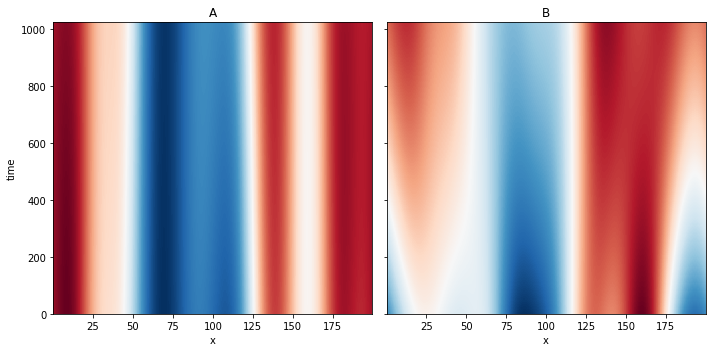

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x.flat, steps_coarse, integrated_fine[k].numpy()[:,0,:,0].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
res['B'].numpy().shape

In [ ]:
integrated_fine['A'].numpy().shape

(257, 9, 800, 1)

(257, 9, 200, 1)

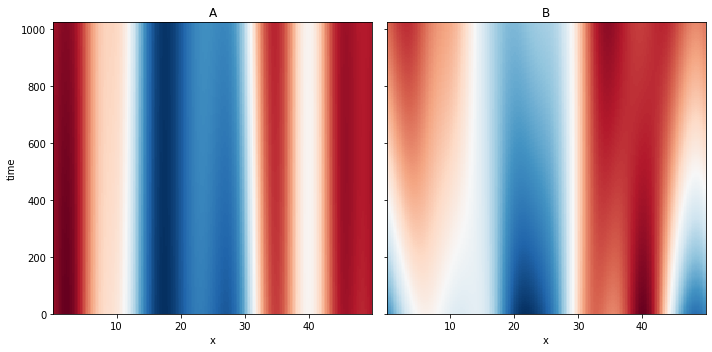

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x_coarse.flat, steps_coarse, integrated_ref[k].numpy()[:,0,:,0].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
integrated_ref['B'].numpy().shape

In [ ]:
train_input, train_output = make_train_data(integrated_ref, example_time_steps=4)
print(type(train_input))

sample key : A

 train_input shape:
A (2277, 200, 1)
B (2277, 200, 1)
Source (2277, 200, 1)

 train_output shape:
A (2277, 4, 200, 1)
B (2277, 4, 200, 1)
<class 'dict'>


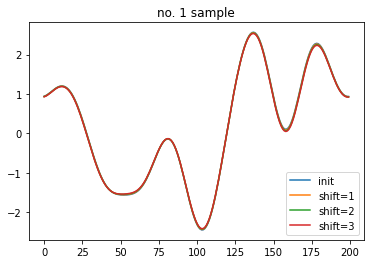

In [ ]:
# make sure that single-step input corresponds to multi-step (advected) output

i_sample = 1  # any number between 0 and train_output.shape[0]

plt.plot(train_input['B'][i_sample].numpy(), label='init')
for shift in range(train_output['B'].shape[0])[:3]:
  plt.plot(train_output['B'][i_sample, shift].numpy(), label=f'shift={shift+1}')

plt.title(f'no. {i_sample} sample')
plt.legend()

In [ ]:
model_nn = pde.core.models.PseudoLinearModel(
    eq, 
    grid_coarse,
    num_time_steps=4,  # multi-step loss function
    stencil_size=3, kernel_size=(3, 1), num_layers=4, filters=32,
    constrained_accuracy_order=1, 
    #learned_keys = {'A_xx','B_xx'},  # finite difference 
    activation='relu',
)

model_nn.learned_keys, model_nn.fixed_keys

({'A_xx', 'B_xx'}, {'A', 'B', 'Source'})

In [ ]:
tf.random.set_random_seed(1)
#%time integrated_untrained = pde.core.integrate.integrate_times(model_nn, initial_state, times=times)
steps2 = np.arange(0, 256*4+1)
res_nn = pde.core.integrate.integrate_steps(model_nn, initial_state_coarse, steps2)
res_nn['A'].numpy().shape

(1025, 9, 200, 1)

In [ ]:
initial_state_coarse['A'].numpy().shape

(9, 200, 1)

(257, 9, 200, 1)

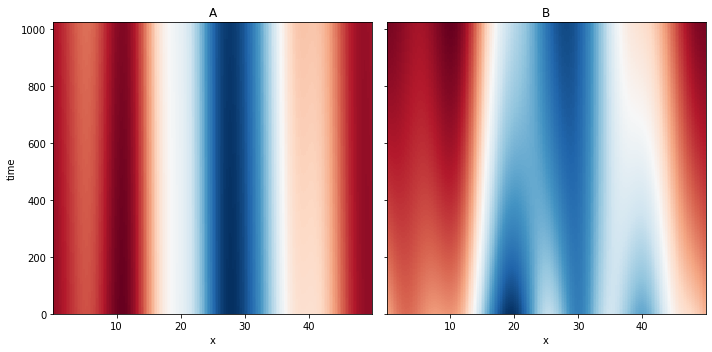

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x_coarse.flat, steps, res_nn[k].numpy()[:,0,:,0].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
integrated_ref['B'].numpy().shape

In [ ]:
%%time 
# same as training standard Keras model
optimizer = tf.keras.optimizers.Adam(lr=0.000001)
model_nn.compile(
    optimizer=optimizer, loss='mae'
    )

tf.random.set_random_seed(0)
np.random.seed(0)
print(type(train_output['B']))
labels=[v for v in train_output.values()]
inputs=[v for v in train_input.values()]
print((labels[0][:,:,:,:].shape))
print(type(labels))


<class 'tensorflow.python.framework.ops.EagerTensor'>
(2277, 4, 200, 1)
<class 'list'>
CPU times: user 4.91 ms, sys: 1 ms, total: 5.92 ms
Wall time: 5.93 ms


In [ ]:
train_output_stacked = [tf.stack(labels, axis=-1)]
print((train_output_stacked[0].shape))

n_var, merged, n_ts, n_x, n_y = train_output_stacked[0].shape
new_output_tensor = tf.reshape(train_output_stacked, [n_var * merged, n_ts, n_x, n_y])
print(new_output_tensor.shape)
tf.__version__, tf.keras.__version__

(2277, 4, 200, 1, 2)
(9108, 200, 1, 2)


('1.15.2', '2.2.4-tf')

In [ ]:
history = model_nn.fit( train_input, labels, epochs=120, batch_size=512,  verbose=1, shuffle=True, use_multiprocessing=True)

Instructions for updating:
ksizes is deprecated, use sizes instead
Train on 2277 samples
Epoch 1/120
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2277/2277 [==============================] - 11s 5ms/sample - loss: 0.0357 - output_1_loss: 0.0156 - output_2_loss: 0.0196
Epoch 2/120
2277/2277 [==============================] - 7s 3ms/sample - loss: 0.0357 - output_1_loss: 0.0160 - output_2_loss: 0.0196
Epoch 3/120
2277/2277 [==============================] - 7s 3ms/sample - loss: 0.0357 - output_1_loss: 0.0157 - output_2_loss: 0.0197
Epoch 4/120
2277/2277 [==============================] - 7s 3ms/sample - loss: 0.0357 - output_1_loss: 0.0163 - output_2_loss: 0.0198
Epoch 5/120
2277/2277 [==============================] - 7s 3ms/sample - loss: 0.0357 - output_1_loss: 0.0161 - output_2_loss: 0.0198
Epoch 6/120
2277/2277 [==============================] - 7s 3ms/sample - loss: 0.0357 - output_1_loss: 0.0160 - output_2_loss: 0.0197
Epoch 7/120


In [ ]:
%time integrated_nn = pde.core.integrate.integrate_steps(model_nn, initial_state_coarse, steps_coarse)

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x_coarse.flat, steps_coarse, res_nn[k].numpy()[:,0,:,:].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
integrated_ref['B'].numpy().shape

In [ ]:
import pandas as pd

df_history = pd.DataFrame(history.history)
df_history['loss'].plot(marker='.')

print(type(df_history))

In [ ]:
res_coarse = pde.core.integrate.integrate_steps(model, initial_state_coarse, steps_coarse)

In [ ]:
fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, k in zip(axs, ['A','B']):
    ax.pcolormesh(x_coarse.flat, steps_coarse, initial_state_coarse[k].numpy()[:,0,:,:].squeeze(), cmap='RdBu')
    ax.set_title(k)
    ax.set_xlabel('x')
axs[0].set_ylabel('time')
fig.tight_layout()
integrated_ref['B'].numpy().shape